In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import sys
import random
import os
import seaborn as sns

In [2]:
graf_dir = 'salidas/Gráficas'
tab_dir = 'salidas/Tablas'

### Cargar la base y limpiar los datos

In [3]:
muestra = pd.read_excel('Muestra_Prueba.xlsx', na_values = "\\N")
muestra.shape

(2625, 14)

In [4]:
muestra.columns = ['id', 'fuente', 'id_conjunto',
                   'tipo', 'nombre_contacto',
                   'telefono_contacto', 'precio_solicitado', 
                   'area', 'piso', 'garajes','ascensores', 
                   'estrato', 'upz', 'antiguedad']

In [5]:
muestra.iloc[2617,]

id                      1107196
fuente                  Ventana
id_conjunto             b728150
tipo                        NaN
nombre_contacto             NaN
telefono_contacto    *****73034
precio_solicitado     155000000
area                         40
piso                         15
garajes                       0
ascensores                    1
estrato                     NaN
upz                    CASTILLA
antiguedad                  NaN
Name: 2617, dtype: object

In [6]:
muestra.iloc[1233,]

id                       1109102
fuente                   Ventana
id_conjunto              b647113
tipo                 Apartamento
nombre_contacto        Constanza
telefono_contacto     *****31241
precio_solicitado      360000000
area                          86
piso                           8
garajes                        1
ascensores                     1
estrato                        3
upz                     BRITALIA
antiguedad                     6
Name: 1233, dtype: object

In [7]:
# Se eliminan las columnas que no tienen importancia para el análisis
muestra = muestra.drop(columns = ['nombre_contacto', 'telefono_contacto'])

# Se pone el precio total solicitado en millones de pesos
muestra.precio_solicitado = muestra.precio_solicitado / 1e6
# Se crea el precio por metro cuadrado
muestra['precio_m2'] = muestra.precio_solicitado / muestra.area

# Hay una observación con antigüedad = 2014, se elimina ese valor
muestra.loc[muestra.antiguedad > 200, 'antiguedad'] = np.nan

# Se corrigen las categorías del tipo del inmueble
muestra.loc[muestra.tipo == 'apartamento','tipo'] = 'Apartamento'
muestra.loc[muestra.tipo == 'casa','tipo'] = 'Casa'
muestra.loc[muestra.tipo == 0, 'tipo'] = np.nan

# Se eliminan los valores "error" en la UPZ
muestra.loc[muestra.upz == 'error','upz'] = np.nan

# Marcar como NA los inmuebles con estrato 0
muestra.loc[muestra.estrato == 0,'estrato'] = np.nan

In [8]:
muestra.tipo.value_counts(normalize=True)

Apartamento    0.971499
Casa           0.028501
Name: tipo, dtype: float64

In [9]:
na_df = pd.DataFrame(muestra.drop('precio_m2', axis=1).isna().sum())
na_df.columns = ['Obs. faltantes']
na_df['Variable'] =  na_df.index
with open(f"{tab_dir}/tabla_na.tex", "w") as f:
    f.write(na_df.to_latex(float_format="%.0f", 
                                index=False,
                                columns=['Variable', 'Obs. faltantes'],
                                column_format='rc'))
na_df

,Obs. faltantes,Variable
id,0,id
fuente,0,fuente
id_conjunto,0,id_conjunto
tipo,204,tipo
precio_solicitado,0,precio_solicitado
area,0,area
piso,0,piso
garajes,0,garajes
ascensores,0,ascensores
estrato,192,estrato


In [10]:
# Se eliminan las observaciones que tienen valores faltanes las variables antigüedad y estrato
print(muestra.shape)
n_drop_tot = 0
for col in ['antiguedad', 'estrato', 'upz'] :
    
    index_keep = 1 - muestra.isna()[col]
    muestra = muestra[index_keep == 1]
    
    n_drop = sum(1 - index_keep)
    print(f'Se eliminaron {n_drop} observaciones que tienen NA en la variable {col}.')
    n_drop_tot += n_drop
print(muestra.shape)
print(f'Se eliminaron {n_drop_tot} observaciones en total.')

(2625, 13)
Se eliminaron 114 observaciones que tienen NA en la variable antiguedad.
Se eliminaron 79 observaciones que tienen NA en la variable estrato.
Se eliminaron 290 observaciones que tienen NA en la variable upz.
(2142, 13)
Se eliminaron 483 observaciones en total.


In [11]:
muestra.isna().sum()

id                    0
fuente                0
id_conjunto           0
tipo                 27
precio_solicitado     0
area                  0
piso                  0
garajes               0
ascensores            0
estrato               0
upz                   0
antiguedad            0
precio_m2             0
dtype: int64

In [12]:
estrato_df = pd.DataFrame(muestra.estrato.value_counts())
estrato_df.columns = ['N']
estrato_df['Estrato'] = estrato_df.index.astype(int)
with open(f"{tab_dir}/tabla_estrato.tex", "w") as f:
    f.write(estrato_df.to_latex(float_format="%.0f", 
                                index=False,
                                columns=['Estrato', 'N'],
                                column_format='rc'))
estrato_df

,N,Estrato
3.0,1085,3
4.0,563,4
2.0,262,2
5.0,203,5
6.0,28,6
1.0,1,1


In [13]:
muestra.shape

(2142, 13)

In [14]:
precio_estrato_df = pd.DataFrame(muestra.precio_solicitado[muestra.estrato > 1].groupby(muestra.estrato).mean())
precio_estrato_df.columns = ['Precio promedio (millones)']
precio_estrato_df.index.name = None
precio_estrato_df['Estrato'] = precio_estrato_df.index.astype(int)
precio_estrato_df['D.E.'] = muestra.precio_solicitado[muestra.estrato > 1].groupby(muestra.estrato).std()
with open(f"{tab_dir}/tabla_precio_estrato.tex", "w") as f:
    f.write(precio_estrato_df.to_latex(float_format="%.3f", 
                                index=False,
                                columns=['Estrato', 'Precio promedio (millones)', 'D.E.'],
                                column_format='rcc'))
precio_estrato_df

,Precio promedio (millones),Estrato,D.E.
2.0,137.885327,2,33.577958
3.0,245.057512,3,150.385163
4.0,354.829130,4,140.052880
5.0,514.960591,5,200.304146
6.0,658.392857,6,247.973616


In [15]:
precio_m2_estrato_df = pd.DataFrame(muestra.precio_m2[muestra.estrato > 1].groupby(muestra.estrato).mean())
precio_m2_estrato_df.columns = ['Precio $m^2$ promedio (millones)']
precio_m2_estrato_df.index.name = None
precio_m2_estrato_df['Estrato'] = precio_m2_estrato_df.index.astype(int)
precio_m2_estrato_df['D.E.'] = muestra.precio_m2[muestra.estrato > 1].groupby(muestra.estrato).std()
with open(f"{tab_dir}/tabla_precio_m2_estrato.tex", "w") as f:
    f.write(precio_m2_estrato_df.to_latex(float_format="%.3f", 
                                index=False,
                                columns=['Estrato', 'Precio $m^2$ promedio (millones)', 'D.E.'],
                                column_format='rcc'))
precio_m2_estrato_df

,Precio $m^2$ promedio (millones),Estrato,D.E.
2.0,2.755069,2,0.703285
3.0,3.596208,3,1.126719
4.0,4.430224,4,0.916173
5.0,4.679898,5,1.041000
6.0,6.436678,6,1.180510


## Análisis gráfico

### Precio total solicitado de los inmuebles

In [16]:
plt.rcParams.update({'font.size': 18})

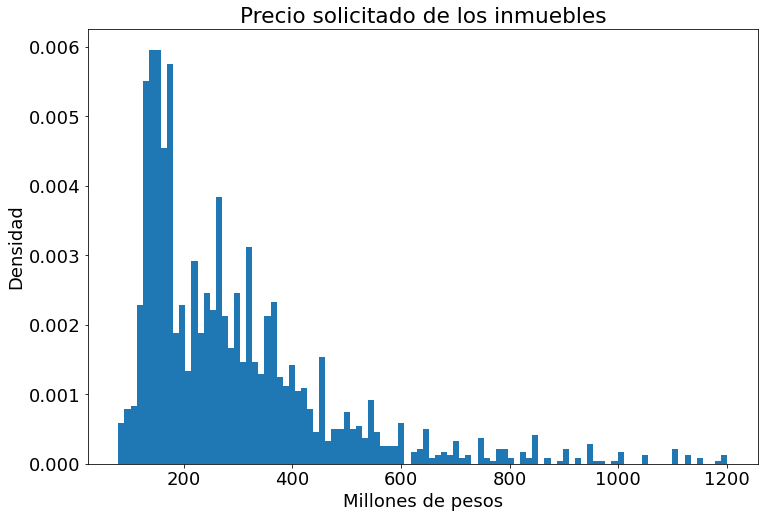

In [17]:
plt.figure(figsize=(12,8))
plt.hist(muestra.precio_solicitado, bins=100, density=True, stacked=True)
plt.gca().set(title='Precio solicitado de los inmuebles', ylabel='Densidad', 
              xlabel='Millones de pesos')
plt.savefig(f'{graf_dir}/hist_precio.pdf', dpi=1000)
plt.show()

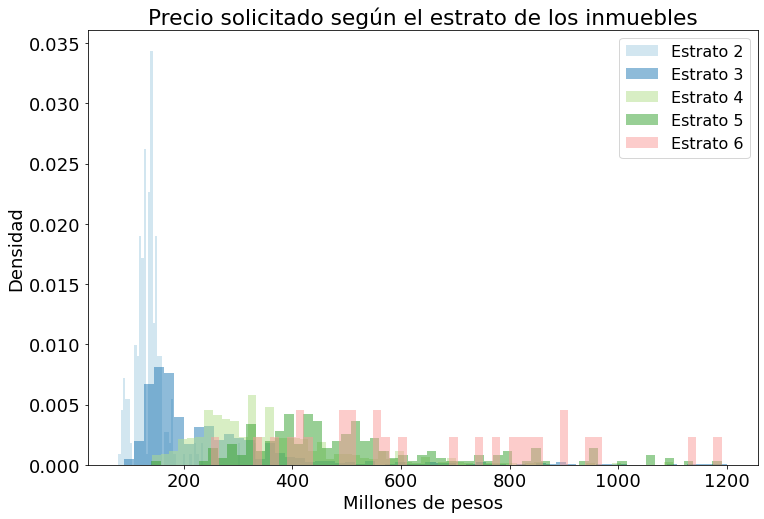

In [18]:
lista_estratos = [2, 3, 4, 5, 6]

colores = sns.color_palette("Paired", len(lista_estratos))
kwargs = dict(alpha=0.5, bins=60, density=True, stacked=True)

labels_estratos = [f'Estrato {e}' for e in lista_estratos]

precio_estratos = {i: muestra.precio_solicitado[(muestra.estrato == i)] for i in lista_estratos}

plt.figure(figsize=(12,8))
cont = 0
for k, v in precio_estratos.items():
    plt.hist(v, **kwargs, color=colores[cont], label=labels_estratos[cont])
    cont += 1
plt.gca().set(title='Precio solicitado según el estrato de los inmuebles', ylabel='Densidad', 
              xlabel='Millones de pesos')
plt.legend(fontsize=16)
plt.savefig(f'{graf_dir}/hist_precio_estrato.pdf')
plt.show()

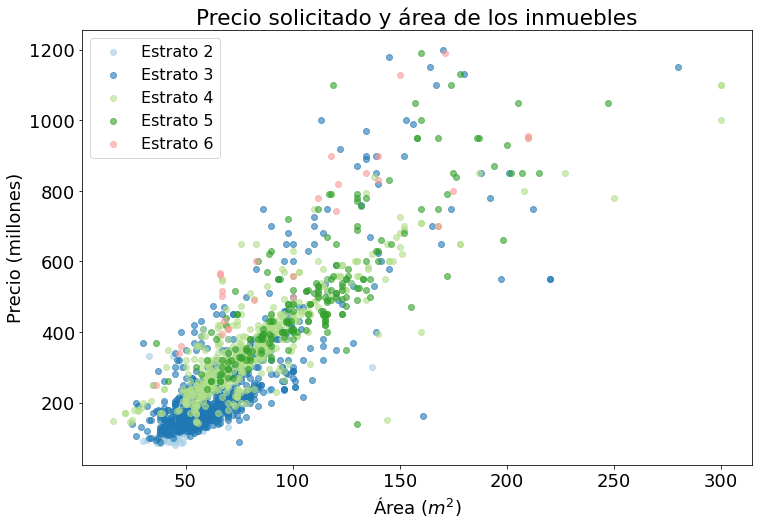

In [19]:
lista_estratos = [2, 3, 4, 5, 6]

colores = sns.color_palette("Paired", len(lista_estratos))
kwargs = dict(alpha=0.6)

labels_estratos = [f'Estrato {e}' for e in lista_estratos]

precio_estratos = {i: muestra.precio_solicitado[(muestra.estrato == i)] for i in lista_estratos}
area_estratos = {i: muestra.area[(muestra.estrato == i)] for i in lista_estratos}

plt.figure(figsize=(12,8))
cont = 0
for k in precio_estratos.keys():
    plt.scatter(area_estratos[k], precio_estratos[k], **kwargs, color=colores[cont], label=labels_estratos[cont])
    cont += 1
plt.gca().set(title='Precio solicitado y área de los inmuebles', ylabel='Precio (millones)', 
              xlabel='Área ($m^2$)')
plt.legend(fontsize=16)
plt.savefig(f'{graf_dir}/scatter_precio_area.pdf')
plt.show()

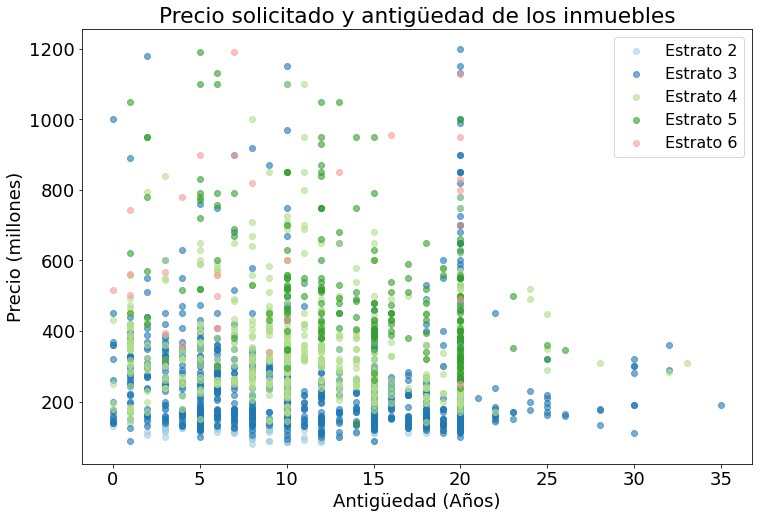

In [20]:
lista_estratos = [2, 3, 4, 5, 6]

colores = sns.color_palette("Paired", len(lista_estratos))
kwargs = dict(alpha=0.6)

labels_estratos = [f'Estrato {e}' for e in lista_estratos]

precio_estratos = {i: muestra.precio_solicitado[(muestra.estrato == i)] for i in lista_estratos}
antig_estratos = {i: muestra.antiguedad[(muestra.estrato == i)] for i in lista_estratos}

plt.figure(figsize=(12,8))
cont = 0
for k in precio_estratos.keys():
    plt.scatter(antig_estratos[k], precio_estratos[k], **kwargs, color=colores[cont], label=labels_estratos[cont])
    cont += 1
plt.gca().set(title='Precio solicitado y antigüedad de los inmuebles', ylabel='Precio (millones)', 
              xlabel='Antigüedad (Años)')
plt.legend(fontsize=16)
plt.savefig(f'{graf_dir}/scatter_precio_antig.pdf')
plt.show()

### Precio por metro cuadrado solicitado de los inmuebles

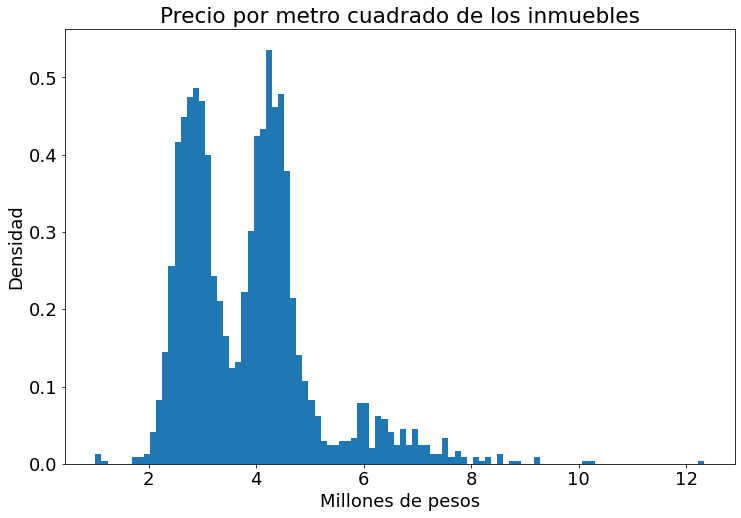

In [21]:
plt.figure(figsize=(12,8))
plt.hist(muestra.precio_m2, bins=100, density=True, stacked=True)
plt.gca().set(title='Precio por metro cuadrado de los inmuebles', ylabel='Densidad', 
              xlabel='Millones de pesos')
plt.savefig(f'{graf_dir}/hist_precio_m2.pdf')
plt.show()

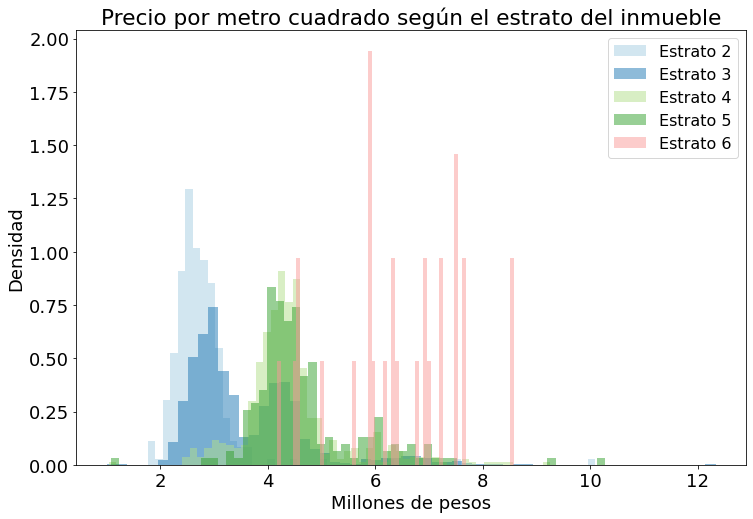

In [22]:
lista_estratos = [2, 3, 4, 5, 6]

colores = sns.color_palette("Paired", len(lista_estratos))
kwargs = dict(alpha=0.5, bins=60, density=True, stacked=True)

labels_estratos = [f'Estrato {e}' for e in lista_estratos]

precio_m2_estratos = {i: muestra.precio_m2[(muestra.estrato == i)] for i in lista_estratos}

plt.figure(figsize=(12,8))
cont = 0
for k, v in precio_m2_estratos.items():
    plt.hist(v, **kwargs, color=colores[cont], label=labels_estratos[cont])
    cont += 1
plt.gca().set(title='Precio por metro cuadrado según el estrato del inmueble', ylabel='Densidad', 
              xlabel='Millones de pesos')
plt.legend(fontsize=16)
plt.savefig(f'{graf_dir}/hist_precio_m2_estrato.pdf')
plt.show()

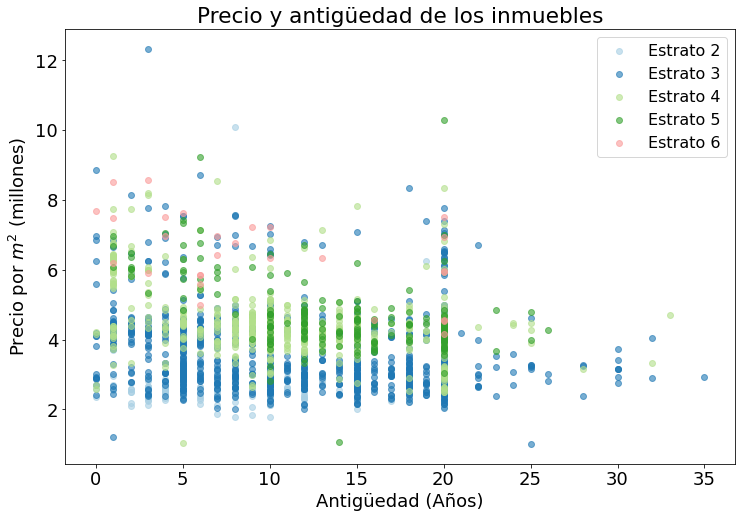

In [23]:
lista_estratos = [2, 3, 4, 5, 6]

colores = sns.color_palette("Paired", len(lista_estratos))
kwargs = dict(alpha=0.6)

labels_estratos = [f'Estrato {e}' for e in lista_estratos]

precio_m2_estratos = {i: muestra.precio_m2[(muestra.estrato == i)] for i in lista_estratos}
antig_estratos = {i: muestra.antiguedad[(muestra.estrato == i)] for i in lista_estratos}

plt.figure(figsize=(12,8))
cont = 0
for k in precio_m2_estratos.keys():
    plt.scatter(antig_estratos[k], precio_m2_estratos[k], **kwargs, color=colores[cont], label=labels_estratos[cont])
    cont += 1
plt.gca().set(title='Precio y antigüedad de los inmuebles', ylabel='Precio por $m^2$ (millones)', 
              xlabel='Antigüedad (Años)')
plt.legend(fontsize=16)
plt.savefig(f'{graf_dir}/scatter_precio_me_antig.pdf')

## Análisis estadístico

In [24]:
ef_upz = pd.get_dummies(muestra['upz'])
ef_upz.iloc[:,1] = 0

ef_conjunto = pd.get_dummies(muestra['id_conjunto']) 
ef_conjunto.iloc[:,1] = 0

ef_estrato = pd.get_dummies(muestra['estrato']) 
ef_estrato.iloc[:,1] = 0

y = np.array(muestra.precio_m2).reshape(-1,1)
X = np.concatenate((muestra[['piso', 'garajes', 'antiguedad', 'ascensores']], 
                    ef_upz,
                    ef_estrato),
                    axis=1)
col_X = ['Intercepto', 'Piso', 'Garaje', 'Antiguedad', 'Ascensores']
col_X += [x.capitalize() for x in ef_upz.columns] 
col_X += [str(x) for x in ef_estrato.columns]

In [25]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary(yname='Precio', xname=col_X))
muestra['y2_pred'] = est2.predict(X2)

                            OLS Regression Results                            
Dep. Variable:                 Precio   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     47.15
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:37:52   Log-Likelihood:                -2360.5
No. Observations:                2142   AIC:                             4877.
Df Residuals:                    2064   BIC:                             5319.
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercepto            

In [26]:
def results_summary_to_dataframe(results, coef_name):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    coef = results.params
    pvals = results.pvalues
    conf_lower = results.conf_int()[:,0]
    conf_higher = results.conf_int()[:,1]
    sd = est2.HC1_se

    col_result = ['Coeficiente', 'P-valor', '[0.025', '0.975]']
    results_df = pd.DataFrame(columns=col_result)

    for i,b in enumerate(coef) :
        results_temp =[coef[i],pvals[i],conf_lower[i],conf_higher[i]]
        results_temp = pd.DataFrame([[str(round(x,3))[:5] for x in results_temp]],
                                   columns=col_result)
        results_df = results_df.append(results_temp)

        results_temp = pd.DataFrame([[f'({str(sd[i])[:5]})', '', '', '']],
                                        columns=col_result)
        results_df = results_df.append(results_temp)
    
    results_index = [''] * (len(coef) * 2)
    results_index[0::2] = coef_name

    results_df.index = results_index
    
    return results_df

In [27]:
results_summary_to_dataframe(est2, col_X).shape[0]/2

80.0

In [28]:
ols_salida = results_summary_to_dataframe(est2, col_X).iloc[:10,:]
print(ols_salida)

with open(f"{tab_dir}/regresion_lineal.tex", "w") as f:
    f.write(ols_salida.to_latex(index=True,
                                column_format='rcccc'))

           Coeficiente P-valor [0.025 0.975]
Intercepto       3.098     0.0  2.247   3.95
               (0.245)                      
Piso               0.0   0.939  -0.01  0.012
               (0.006)                      
Garaje           0.457     0.0  0.366  0.547
               (0.054)                      
Antiguedad       -0.03     0.0  -0.03  -0.02
               (0.003)                      
Ascensores       0.204     0.0  0.106  0.302
               (0.048)                      


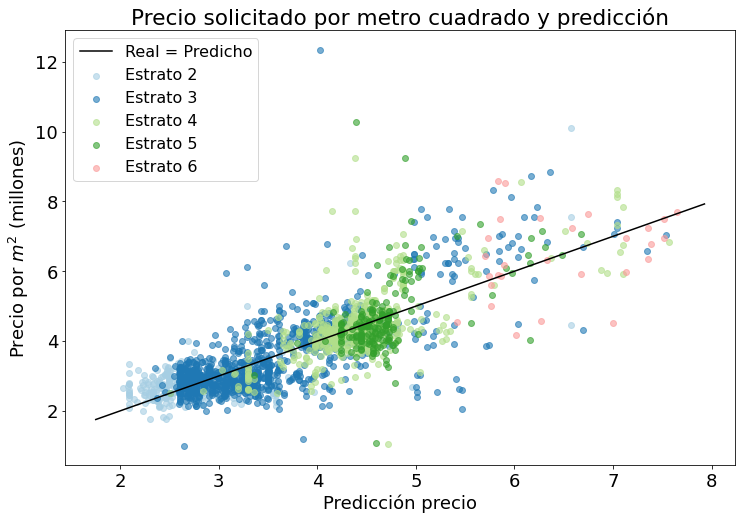

In [29]:
lista_estratos = [2, 3, 4, 5, 6]

colores = sns.color_palette("Paired", len(lista_estratos))
kwargs = dict(alpha=0.6)

labels_estratos = [f'Estrato {e}' for e in lista_estratos]

precio_m2_estratos = {i: muestra.precio_m2[(muestra.estrato == i)] for i in lista_estratos}
precio_m2_pred_estratos = {i: muestra.y2_pred[(muestra.estrato == i)] for i in lista_estratos}

plt.figure(figsize=(12,8))
cont = 0
for k in precio_estratos.keys():
    plt.scatter(precio_m2_pred_estratos[k], precio_m2_estratos[k], **kwargs, color=colores[cont], label=labels_estratos[cont])
    cont += 1
plt.gca().set(title='Precio solicitado por metro cuadrado y predicción', ylabel='Precio por $m^2$ (millones)', 
              xlabel='Predicción precio')
xmin, xmax, ymin, ymax = plt.axis()
plt.plot([xmin, xmax], [xmin, xmax], color='black', label='Real = Predicho')
plt.legend(fontsize=16)
plt.savefig(f'{graf_dir}/scatter_predict_precio_m2.pdf')
plt.show()